# We try to see how our SVM fares

## Loading everything

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import pickle, os
import numpy as np
import matplotlib.pyplot as plt
from cv2 import SIFT_create, imread, cvtColor, COLOR_BGR2GRAY, GaussianBlur
from sklearn.metrics import confusion_matrix

from scripts.utils import extract_frames_info, label_keypoints, annotations_from_string

In [3]:
features_path = "data/features_similar.pkl"
test_features_path = "data/test_features_similar.pkl"
pca_path = "models/pca_similar.pkl"
svm_path = "models/svm_similar.pkl"

with open(features_path, "rb") as feature_file:
    features, labels = pickle.load(feature_file)
    features = np.array(features)
    labels = np.array(labels)

with open(test_features_path, "rb") as test_feature_file:
    test_features, keypoints = pickle.load(test_feature_file)

mean, std = features.mean(0), np.std(features, 0)
c_features = (features - mean) / std

with open(pca_path, "rb") as pca_file:
    pca = pickle.load(pca_file)
with open(svm_path, "rb") as svm_file:
    svm = pickle.load(svm_file)

sift = SIFT_create()

frames_info = extract_frames_info('data/train.csv', only_similar=True)

## Looking at what the SVM can find on the test set

In [10]:
index = 75

first_image = imread(f"data/test/{index:03d}.jpg")
feature_vects = test_features[0]
kps = keypoints[0]
coords = np.array(kps)

c_f = (feature_vects - mean) / std

exp_labels = svm.predict(c_f)

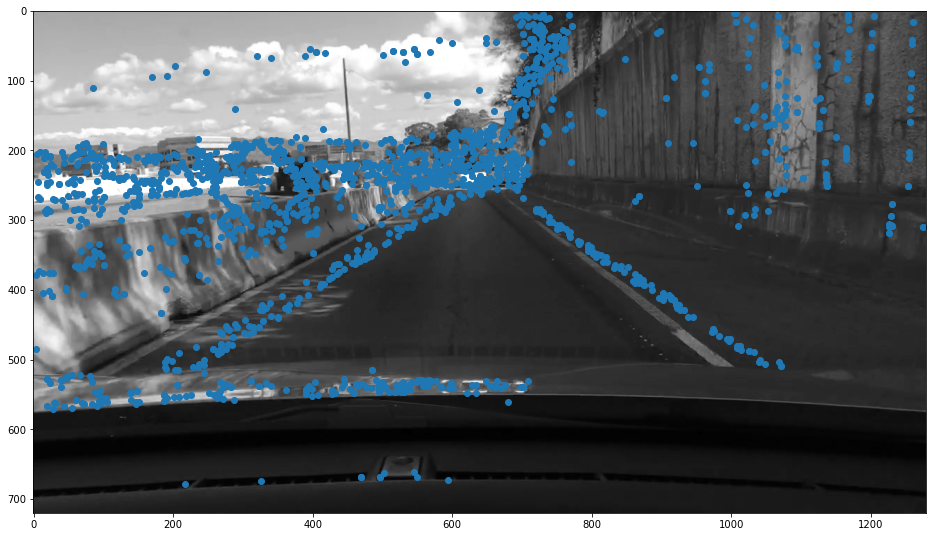

In [12]:
filter = exp_labels.astype(bool)
good_coords = coords[filter]
heatmap, xedges, yedges = np.histogram2d(good_coords[:, 0], good_coords[:, 1], bins=(200, 120))

heatmap = GaussianBlur(heatmap, [0, 0], 2)
# heatmap = np.ma.masked_array(heatmap, heatmap < .05)

plt.figure(figsize=(16, 12))

plt.imshow(cvtColor(first_image, COLOR_BGR2GRAY), cmap="gray")
# plt.pcolormesh(xedges, yedges, heatmap.T, alpha=.7)
plt.scatter(coords[:, 0], coords[:, 1])

## Looking at what the SVM can find on the training set

In [6]:
index = 0
first_image = imread(os.path.join("data", frames_info[index][0]))

kps, f = sift.detectAndCompute(first_image, None)

coords = np.array([kp.pt for kp in kps])

r_f = pca.transform(f)

c_f = (r_f - mean) / std

exp_labels = svm.predict(c_f)
real_labels = label_keypoints(kps, frames_info[index][1])
confusion_matrix(real_labels, exp_labels)

array([[2403,   33],
       [ 161,   40]])

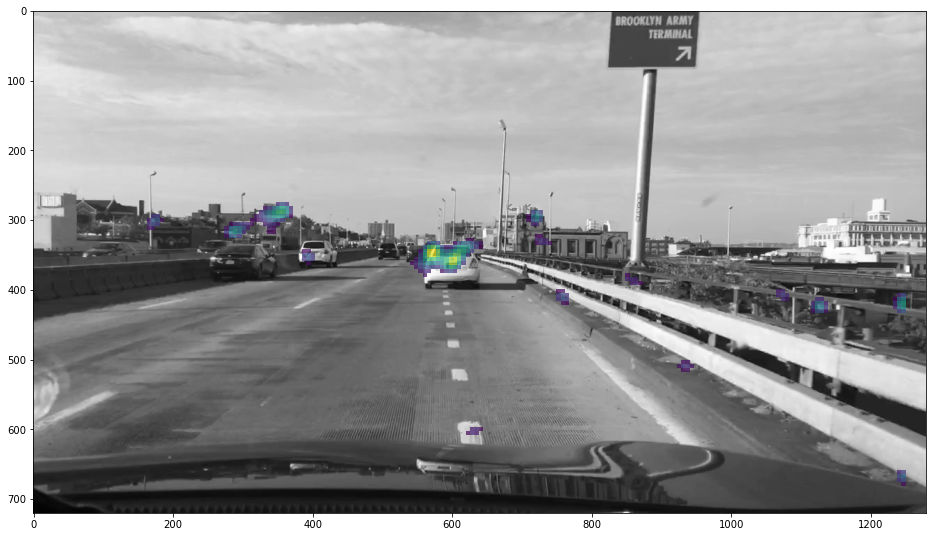

In [25]:
filter = exp_labels.astype(bool)
good_coords = coords[filter]
heatmap, xedges, yedges = np.histogram2d(good_coords[:, 0], good_coords[:, 1], bins=(200, 120))

heatmap = GaussianBlur(heatmap, [0, 0], 2)
heatmap = np.ma.masked_array(heatmap, heatmap < .05)

plt.figure(figsize=(16, 12))

plt.imshow(cvtColor(first_image, COLOR_BGR2GRAY), cmap="gray")
plt.pcolormesh(xedges, yedges, heatmap.T, alpha=.7)
# plt.scatter(coords[:, 0], coords[:, 1])
